# Experiment 5: The model is trained on 3s long samples then evaluated for 1s, 1.5s and 2s data. 


*   Training data from 5 subjects
*   Test data from remaining subject
*   0 degree aspect angle
*   64-128 model

## Notebook setup

Allow editing of modules using editor (auto reloading)

In [0]:
%load_ext autoreload
%autoreload 2

Needed for compatibility when using both CoLab and Local Jupyter notebook. It sets the appropriate file path for the data and also installs local packages such as models and data_loading.

In [2]:
import os
if os.getcwd() == '/content':
    from google.colab import drive
    drive.mount('/content/gdrive')
    BASE_PATH = '/content/gdrive/My Drive/Level-4-Project/'
    !cd gdrive/My\ Drive/Level-4-Project/ && pip install --editable .
    os.chdir('gdrive/My Drive/Level-4-Project/')
    
else:
    BASE_PATH = "C:/Users/macka/Google Drive/Level-4-Project/"
    
DATA_PATH = BASE_PATH + 'data/'
MODEL_PATH = BASE_PATH + 'models/original_experiments/experiment_5/'
FIGURE_PATH = BASE_PATH + 'reports/figures/original_experiments/experiment_5/'
REPORT_PATH = BASE_PATH + 'reports/original_experiments/experiment_5/'

from src.models.original_models import cnn_64_128
from src.data import load_data
from src.visualization import visualize

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Obtaining file:///content/gdrive/My%20Drive/Level-4-Project
  Found existing installation: src 0.1.0
    Can't uninstall 'src'. No files were found to uninstall.
  Running setup.py develop for src


Using TensorFlow backend.


Import remaining packages

In [0]:
import numpy as np
import sys
from six.moves import cPickle
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.utils import np_utils
import sys
from sklearn.metrics import classification_report, confusion_matrix
import csv
from keras.models import load_model

In [0]:
# Needed as originally code was for theano backend but now using tensor flow
from keras import backend as K
K.set_image_dim_ordering('th')

## Experiment Setup and Parameter Definition

In [0]:
data_folders = {'1s':{}, '1_5s':{}, '2s':{}, 'noninitialised_A':{}}
for key, value in data_folders.items():
    value["acc"] = None
    value["loss"] = None
    value["classification_report"] = None
    value["confusion_matrix"] = None
    
target_names = ['ArmFasterTowards', 'ArmSlowerTowards', 'CirclingArm', 'Clapping', 'PickingUp', 'Sitting', 'Walking']

In [0]:
load_model = False

batch_size = 100
nb_classes = 7
nb_epoch = 100
nb_epoch = 2
nb_train_samples = 34720
# input image dimensions
img_rows, img_cols = 75, 75
# the CIFAR10 images are RGB

In [0]:
(X_train, y_train), (X_test, y_test) = load_data.load_data((DATA_PATH + '1s'), nb_train_samples)
Y_train = np_utils.to_categorical(y_train, nb_classes)

In [0]:
if load_model:
    model = load_model(MODEL_PATH + "cnn_64_128.h5")
else:
    model = cnn_64_128.make_model(img_rows, img_cols, nb_classes)

## Training and Evaluating Models


### Train

In [9]:
if not load_model:
    # Train the model using SGD + momentum.
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

    X_train = X_train.astype('float32')
    X_train /= 255

    history = model.fit(
        X_train,
        Y_train,
        batch_size=batch_size,
        epochs=nb_epoch,
        shuffle=True, 
        verbose=1)

Epoch 1/2
34720/34720 [==============================] - 69s 2ms/step - loss: 0.6907 - acc: 0.7380
Epoch 2/2
34720/34720 [==============================] - 66s 2ms/step - loss: 0.1149 - acc: 0.9614


### Evaluate for each dataset

In [10]:
for folder_name, value in data_folders.items():    
    X_test, y_test = load_data.load_batch(DATA_PATH + folder_name + '/test_batch')
    y_test = np.reshape(y_test, (len(y_test), 1))
    Y_test = np_utils.to_categorical(y_test, nb_classes)
    evaluation = model.evaluate(X_test, Y_test, batch_size=batch_size, verbose=1)
    value["loss"] = evaluation[0]
    value["accuracy"] = evaluation[1]

    y_pred = model.predict_classes(X_test)
    value["classification_report"] = classification_report(
        np.argmax(Y_test,axis=1),
        y_pred,target_names=target_names)
    value["confusion_matrix"] = confusion_matrix(
        np.argmax(Y_test,axis=1), y_pred)

6944/6944 [==============================] - 5s 660us/step


## Analysis and Saving of Results

In [0]:
save_graphs = True
save_model = True
save_report = True

### Plot and Save graphs

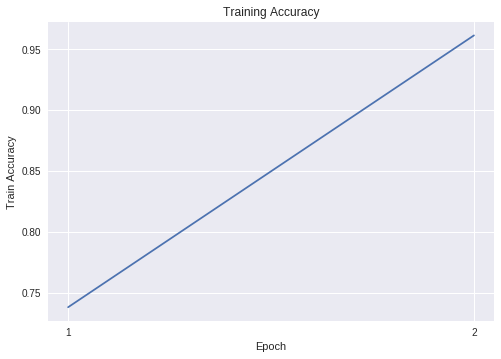

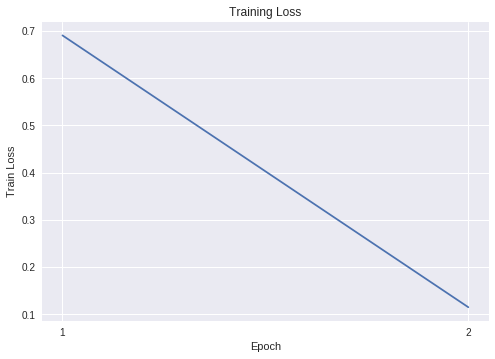

In [11]:
if not load_model:
    visualize.plot_train_acc(
        history, "Training Accuracy", save=save_graphs,
        path=FIGURE_PATH + "model_train_accuracy.svg")
    visualize.plot_train_loss(
        history, "Training Loss", save=save_graphs,
        path=FIGURE_PATH + "model_train_loss.svg")

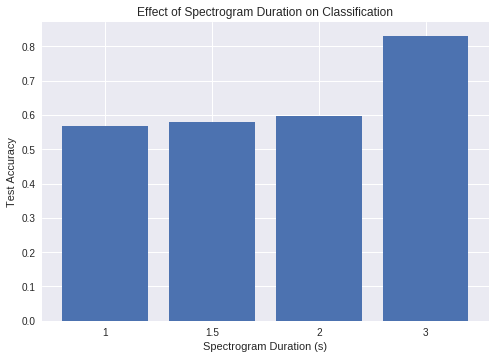

In [12]:
visualize.plot_evaluation_bar(
    data_folders,
    ['1','1.5', '2', '3'],
    "Effect of Spectrogram Duration on Classification",
    'Spectrogram Duration (s)',
    'Test Accuracy',
    save=save_graphs,
    path=FIGURE_PATH + "accuracy.svg")

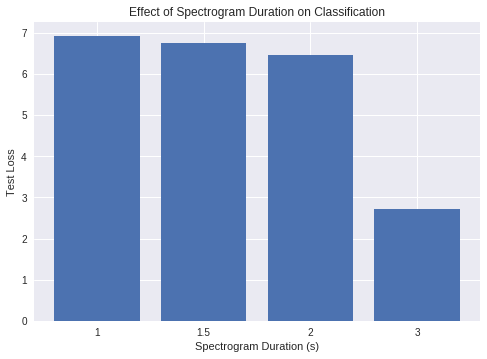

In [13]:
visualize.plot_evaluation_bar(
    data_folders,
    ['1','1.5', '2', '3'],
    "Effect of Spectrogram Duration on Classification",
    'Spectrogram Duration (s)',
    'Test Loss',
    metric="loss",
    save=save_graphs,
    path=FIGURE_PATH + "loss.svg")

### Save Model

In [0]:
if save_model and not load_model:
    model.save(MODEL_PATH + "cnn_64_128.h5")

### Save Classification Report and Confusion Matricies

In [0]:
if save_report:
    file = open(REPORT_PATH + 'Classification_and_Confusion.txt', 'w') 

    for folder_name, value in data_folders.items():    
        file.write("--------------------------------------------------\n") 
        file.write("Test set name: " + folder_name + "\n") 
        file.write("Accuracy: " + str(np.round(value["accuracy"], 2)) + "\n")
        file.write("Loss: " + str(np.round(value["loss"], 2)) + "\n")
        file.write("Classification Report:\n") 
        file.write(value['classification_report'])
        file.write("Confusion Matrix:\n") 
        file.write(np.array2string(value['confusion_matrix']) + "\n")

    file.close() 